In [1]:
%load_ext autoreload
%matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import clipboard
import numpy as np
import os
from IPython.display import clear_output
from PIL import Image
from scipy import spatial
import networkx as nx
import json
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.models import VGG16_Weights
sys.path.append('/Users/orenm/BlenderShaderProject/project_files/')

In [2]:
from Logic.generation_db_and_manager import DBManager
from Logic.generation_db_and_manager import HAS_IMAGE, IS_CLUSTER_BASE, IS_EMPTY_IMAGE, IS_EMPTY_NETWORK, \
ON_PATH_TO_EMPTY, MEGA_NODES_GENERATION, META_NODES_GENERATION, RANDOM_GENERATION
from Logic.utils import lc

In [31]:
def visualize_image_pair(image_pairs, images_dir):
    # Pick a random pair from the list
    pair = random.choice(image_pairs)
    
    # Get file paths for both images
    image_path_1 = f"{images_dir}/{pair[0]}.png"
    image_path_2 = f"{images_dir}/{pair[1]}.png"
    
    # Load the images as grayscale
    img1 = Image.open(image_path_1).convert('L')  # 'L' mode for grayscale
    img2 = Image.open(image_path_2).convert('L')  # 'L' mode for grayscale
    
    # Plot the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Show grayscale images using cmap='gray'
    axes[0].imshow(img1, cmap='gray')
    axes[0].axis('off')  # Hide axes
    axes[0].set_title(f"Image: {pair[0]}")
    
    axes[1].imshow(img2, cmap='gray')
    axes[1].axis('off')  # Hide axes
    axes[1].set_title(f"Image: {pair[1]}")
    
    plt.show()

In [4]:
path = '/Users/orenm/BlenderShaderProject/data/'
images_path = os.path.join(path, 'images/')
db_path = os.path.join(path, 'DB/')

In [5]:
db_manager = DBManager.load(db_path, load_networks_managers=False)

In [6]:
network = db_manager.network

In [7]:
# move to db manager
def can_use(node):
    return not any(x in network.nodes[node]['labels'] for x in [IS_EMPTY_NETWORK, IS_EMPTY_IMAGE])

In [ ]:
# Collect all similar pairs
similar_pairs = []
for u, v, data in lc(network.edges(data=True)):
    if data.get("variation_type") == "SEED" and can_use(u) and can_use(v):
        similar_pairs.append((u, v))

In [61]:
len(similar_pairs)

61006

In [73]:
n_random_nodes = 30000

# Collect all different pairs
different_pairs_random = []
nodes = list(network.nodes())
for _ in lc(range(n_random_nodes)):  # Generate as many different pairs as similar ones
    # Randomly pick two nodes that are not directly connected
    while True:
        node1, node2 = np.random.choice(nodes, 2, replace=False)
        if not network.has_edge(node1, node2) and can_use(node1):
            different_pairs_random.append((node1, node2))
            break

30000/30000


In [72]:
n_random_in_cluster = 30000
distance = 3
different_pairs_cluster = []

for _ in lc(range(n_random_in_cluster)):  # Generate as many different pairs as similar ones
    # Randomly pick two nodes within the same cluster at distance k
    while True:
        node = np.random.choice(nodes)
        # Get all nodes at distance k from the current node
        distances = nx.single_source_shortest_path_length(network, node)
        candidates = [n for n, dist in distances.items() if dist > distance]
        if candidates:
            node2 = np.random.choice(candidates)
            if can_use(node1) and can_use(node2):
                different_pairs_cluster.append((node, node2))
                break

30000/30000


In [32]:
important_params = ['element_0', 'element_1', 'Scale']
cat_numeric_pairs = []
important_params_pairs = []
for u, v, data in lc(network.edges(data=True), print_every=1000):
    if data.get("variation_type") == "CAT_AND_NUMERIC" and can_use(u) and can_use(v):
        if any([any(param in x for param in important_params) for x in data['step'].values()]):
            important_params_pairs.append((u,v))
        else:
            cat_numeric_pairs.append((u, v))

200000/200551


In [36]:
file_path = os.path.join(path, 'texture_cls_pairs.json')
# # Prepare data
# data = {
#     "similar_pairs": similar_pairs,
#     "different_pairs_random": different_pairs_random,
#     "different_pairs_cluster": different_pairs_cluster,
#     'cat_numeric_pairs': cat_numeric_pairs,
#     'important_params_pairs': important_params_pairs,
# }
# Write to JSON
with open(file_path, "w") as json_file:
    json.dump(data, json_file, indent=4)

In [9]:
file_path = os.path.join(path, 'texture_cls_pairs.json')
with open(file_path, "rb") as json_file:
    data = json.load(json_file)

In [10]:
data.keys()

dict_keys(['similar_pairs', 'different_pairs_random', 'different_pairs_cluster'])

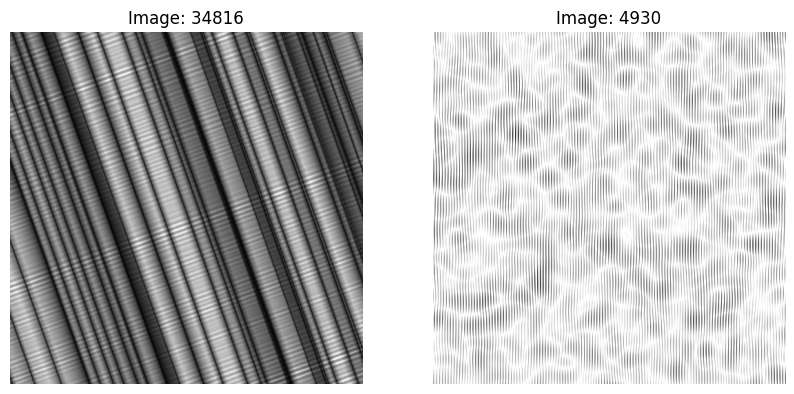

In [302]:
visualize_image_pair(different_pairs_cluster, images_path)

# Getting vectors of features from some layer to compare the images on

In [11]:
def make_1c_vgg():
    vgg_model_1c = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    
    # Modify the first convolutional layer to accept 1 channel input (grayscale)
    # Original first conv layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    # New first conv layer for grayscale input (1 channel):
    original_weight = vgg_model_1c.features[0].weight.data
    
    # Sum or average the weights across the 3 channels to create a 1-channel equivalent
    # Option 1: Sum the weights across the 3 channels (sum across dim=1)
    new_weight = original_weight.sum(dim=1, keepdim=True)  # Sum across 3 channels
    
    # Option 2: Alternatively, you could average the weights
    # new_weight = original_weight.mean(dim=1, keepdim=True)  # Average across 3 channels
    
    # Now replace the first conv layer with the new weight
    vgg_model_1c.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    vgg_model_1c.features[0].weight.data = new_weight  # Set the modified weights
    
    # Initialize bias as usual
    vgg_model_1c.features[0].bias.data = original_weight.mean(dim=(1, 2, 3))  # Use the average bias
    return vgg_model_1c

In [12]:
# Define image transformation (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_grayscale = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),  # Convert to tensor (1 channel will remain as 1 channel)
    # transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize using single-channel mean/std
])

# Load and preprocess the image pair
def load_and_preprocess_image(image_path, as_rgb=True):
    image = Image.open(image_path)
    if as_rgb:
        image = image.convert('RGB')
        return transform(image).unsqueeze(0)  # Add batch dimension
    return transform_grayscale(image).unsqueeze(0)

class ImageFeatureExtractor:
    def __init__(self, vgg_model, as_rgb=True):
        vgg_model.eval()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        vgg_model = vgg_model.to(self.device)
        self.as_rgb = as_rgb
        
        self.vgg_model = vgg_model

    def get_vectors(self, img_path, layer):
        activations = []
        
        def hook_fn(module, input, output):
            # Save the output activations
            activations.append(output)
    
        # Load and preprocess image
        img = load_and_preprocess_image(img_path, as_rgb=self.as_rgb)
        img = img.to(self.device)
        
        # Register the hook to the layer we want to visualize (e.g., 28th layer for VGG16)
        hook = self.vgg_model.features[layer].register_forward_hook(hook_fn)
    
        # Pass the image through the network to get activations
        with torch.no_grad():
            self.vgg_model(img)
        
        # Get the activations and flatten them (ensure it's done before deletion)
        activation_tensor = activations[0].flatten()
        activation_vector = activation_tensor.cpu().numpy()
    
        # Now you can delete activations and clear memory
        activations.clear()
        del img  # Optional: If you want to free image tensor memory
    
        # Clear the GPU cache to free unused memory
        # torch.cuda.empty_cache()
    
        return activation_vector

    def get_sample_similairities(self, img_pairs, layer, n=100):    
        similarities = []
        for i in lc(range(100)):
            node1, node2 = random.choice(img_pairs)
            image_path_1 = db_manager.make_image_path(node1, images_path)
            image_path_2 = db_manager.make_image_path(node2, images_path)
        
            vec1 = self.get_vectors(image_path_1, layer=layer)
            vec2 = self.get_vectors(image_path_2, layer=layer)
            
            similarities.append(1 - spatial.distance.cosine(vec1, vec2))
        return similarities

In [13]:
def print_vram():
    device = torch.cuda.current_device()
    
    # Get the total memory and the memory allocated
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)
    
    # Convert to MB for easier reading
    total_memory_MB = total_memory / (1024 ** 2)
    allocated_memory_MB = allocated_memory / (1024 ** 2)
    cached_memory_MB = cached_memory / (1024 ** 2)
    
    print(f"Total memory: {total_memory_MB:.2f} MB")
    print(f"Allocated memory: {allocated_memory_MB:.2f} MB")
    print(f"Cached memory: {cached_memory_MB:.2f} MB")

In [14]:
similar_pairs = data['similar_pairs']
different_pairs_cluster = data['different_pairs_cluster']

In [78]:
vgg_model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
imf = ImageFeatureExtractor(vgg_model)

In [79]:
by_layer = {}
for layer in [28, 14, 21]:
    now = time.time()
    torch.cuda.empty_cache()

    sims_vals = imf.get_sample_similairities(similar_pairs, layer=layer, n=100)
    diffs_vals = imf.get_sample_similairities(different_pairs_cluster, layer=layer, n=100)
    by_layer[layer] = (sims_vals, diffs_vals, time.time()-now)

100/100


In [80]:
for layer, (sims, diffs, t) in by_layer.items():
    print(layer, round(t, 2))
    print(np.mean(sims), np.mean(diffs))

28 4.91
0.4290609538609775 0.27224198608273137
14 5.17
0.3432386421133488 0.3169262903023036
21 5.08
0.3992409835142902 0.29006199050800907


In [18]:
vgg_model_1c = make_1c_vgg()
imf = ImageFeatureExtractor(vgg_model_1c, as_rgb=False)

In [19]:
by_layer = {}
for layer in [28, 14, 21]:
    now = time.time()
    torch.cuda.empty_cache()

    sims_vals = imf.get_sample_similairities(similar_pairs, layer=layer, n=100)
    diffs_vals = imf.get_sample_similairities(different_pairs_cluster, layer=layer, n=100)
    by_layer[layer] = (sims_vals, diffs_vals, time.time()-now)

100/100


In [17]:
for layer, (sims, diffs, t) in by_layer.items():
    print(layer, round(t, 2))
    print(np.mean(sims), np.mean(diffs))

28 14.51
0.49909705854200537 0.27933632716076934
14 4.81
0.4050875240483425 0.3610146062889097
21 4.51
0.4424440515416282 0.3491279562507058
